In [ ]:
%pylab inline

In [ ]:
from datetime import date
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import linear_model, tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import ensemble

In [ ]:
def get_names(dataframe):
    cols = dataframe.columns
    s = set()
    for col in cols:
        s.add(col[:col.find("_")])
    return list(s)

In [ ]:
data = pd.read_csv("./data.csv")

In [ ]:
data.reindex_axis(sorted(data.columns), axis=1)
data.set_index("Date", inplace=True)
data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)

In [ ]:
all_stocks = get_names(data)
use_stocks = ["GOOGL", "AAPL", "NFLX", "AMZN", "QCOM", "SBUX"]

In [ ]:
def select_stocks(dataframe, stocks):
    transformed = list(map(lambda x : x + "_Cls%", stocks))
    selected = dataframe[transformed]
    selected.columns = stocks
    return selected

In [ ]:
selected = select_stocks(data, use_stocks)
selected_all = select_stocks(data, all_stocks)

In [ ]:
dataset = selected.tail(1100)

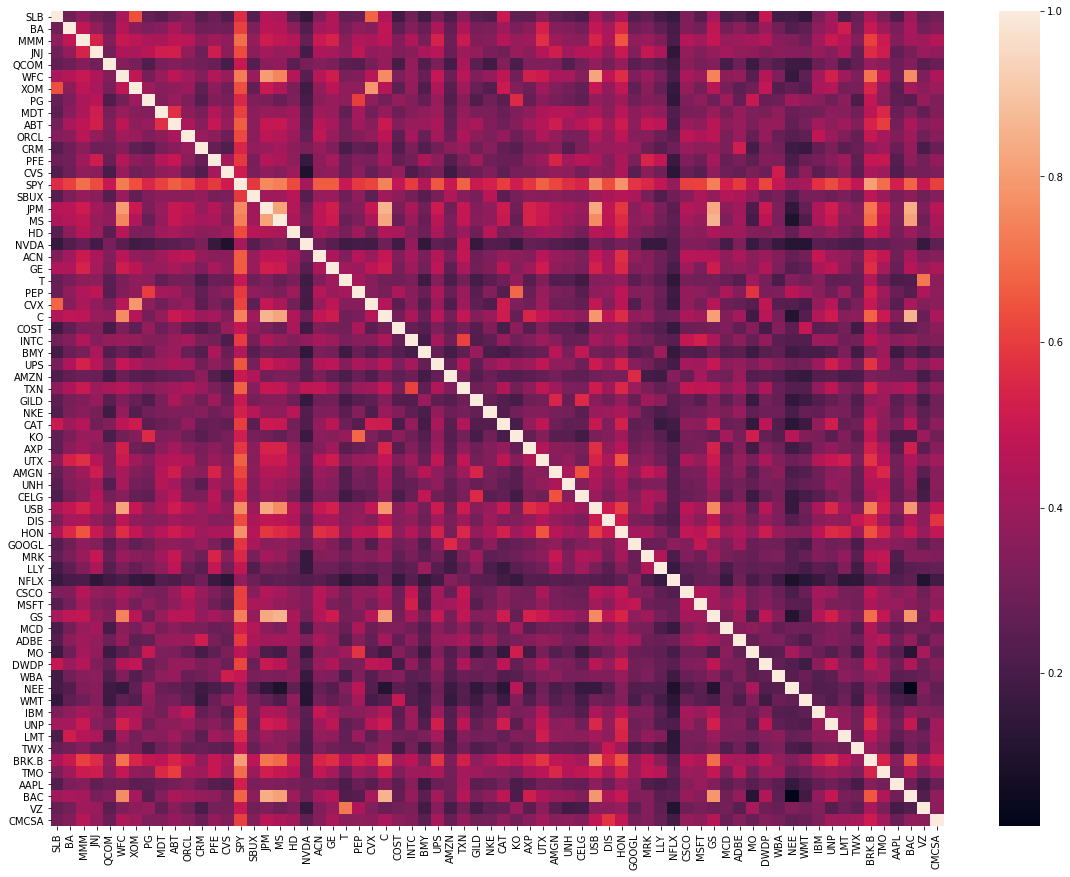

In [10]:
corr = selected_all.tail(1100).corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [11]:
dataset.corr()

,GOOGL,AAPL,NFLX,AMZN,QCOM,SBUX
GOOGL,1.000000,0.352547,0.362140,0.556565,0.247930,0.429022
AAPL,0.352547,1.000000,0.225136,0.302596,0.295702,0.315319
NFLX,0.362140,0.225136,1.000000,0.348343,0.182182,0.289736
AMZN,0.556565,0.302596,0.348343,1.000000,0.193580,0.438427
QCOM,0.247930,0.295702,0.182182,0.193580,1.000000,0.231536
SBUX,0.429022,0.315319,0.289736,0.438427,0.231536,1.000000


In [12]:
raw_dataset = dataset.tail(1000)
raw_outputs = raw_dataset.as_matrix()
feature_ma2 = dataset.rolling(window = 2, center=False).mean().tail(1000)
feature_ma3 = dataset.rolling(window = 3, center=False).mean().tail(1000)
feature_ma5 = dataset.rolling(window = 5, center=False).mean().tail(1000)
feature_ma10 = dataset.rolling(window = 10, center=False).mean().tail(1000)
feature_ma30 = dataset.rolling(window = 30, center=False).mean().tail(1000)
features = np.hstack([feature_ma2, feature_ma3, feature_ma5 ,feature_ma10,feature_ma30])

1 - linear regression model =)

In [13]:
X_train_lin, X_test_lin, y_train_lin, y_test_lin=train_test_split(features, raw_outputs, test_size = 0.2, shuffle=False)

In [14]:
lin_model = linear_model.LinearRegression(fit_intercept=True)

In [15]:
lin_model.fit(X_train_lin, y_train_lin)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
y_train_prediction_lin = lin_model.predict(X_train_lin)

train dataset scores

In [17]:
print(r2_score(y_train_lin, y_train_prediction_lin, multioutput = "raw_values"))
print(mean_squared_error(y_train_lin, y_train_prediction_lin, multioutput = "raw_values"))

[ 0.56160659  0.52626102  0.54399488  0.5000163   0.51401753  0.54529114]
[ 0.93952113  1.08654753  3.67451703  1.95449088  1.34510548  0.71939665]


In [18]:
y_test_prediction_lin = lin_model.predict(X_test_lin)

In [19]:
print(r2_score(y_test_lin, y_test_prediction_lin, multioutput = "raw_values"))
print(mean_squared_error(y_test_lin, y_test_prediction_lin, multioutput = "raw_values"))

[ 0.50168657  0.45516825  0.44618639  0.4946287   0.47462237  0.47877944]
[ 0.49337469  0.58386754  1.8602105   0.97001293  1.10080768  0.64376836]


2 - Decision Tree Regressor

In [20]:
X_train_tree, X_test_tree, y_train_tree, y_test_tree=train_test_split(features, raw_outputs, test_size = 0.2, shuffle=False)

In [21]:
tree_regression = tree.DecisionTreeRegressor(min_samples_leaf=5)

In [22]:
tree_regression.fit(X_train_tree, y_train_tree)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [23]:
y_train_prediction_tree = tree_regression.predict(X_train_tree)

In [ ]:
print(r2_score(y_train_tree, y_train_prediction_tree, multioutput = "raw_values"))
print(mean_squared_error(y_train_tree, y_train_prediction_tree, multioutput = "raw_values"))

In [ ]:
y_test_prediction_tree = tree_regression.predict(X_test_tree)

In [ ]:
print(r2_score(y_test_tree, y_test_prediction_tree, multioutput = "raw_values"))
print(mean_squared_error(y_test_tree, y_test_prediction_tree, multioutput = "raw_values"))